### Generate adata from supplemental data from Hill et al. 2022

https://doi.org/10.1038/s41586-022-04989-3

Control cardiac tissue samples from donors were collected from the University of Kentucky (Samples UK1/FC3CB and UK2/3B62D) and Washington University in St Louis (LV198/RV198/13–198 and RV325/13235)

All scRNA-seq and snRNA-seq were performed by using the 10X Genomics platform. Cells or nuclei were isolated as described earlier and were loaded into the 10X Genomics Chromium Controller to obtain the gel beads in emulsion. The sequencing libraries were then prepared according to the 10X genomics protocol for Single Cell 3' Reagents Kit v3.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
from collections import Counter
import re
import scanpy.external as sce

In [2]:
def preprocess_adata(adata, donor_key, leiden_resolution):
    '''
    Performs: 
    1. library size normalization and log scaling
    2. identification of top 2K highly variable genes, 
    3. Principal component analysis
    4. Harmony integration
    5. Neighbor neighbors computation in Harmony integration embedding
    6. Leiden clustering 
    
    Parameters:
    adata (AnnData): adata object before preprocessing
    donor_key: the column in adata.obs that corresponds to the donor information (should be 'donor_id')
    leiden_resolution: resolution for leiden clustering, higher means more clusters will be detected

    Returns:
    adata: Postprocessed adata
    '''
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key=donor_key)
    sc.tl.pca(adata)
    sce.pp.harmony_integrate(adata, donor_key)
    sc.pp.neighbors(adata, use_rep = "X_pca_harmony")
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=donor_key, size=2)
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 0.5)
    return(adata)

### Load in the full Hill adata

In [3]:
adata = sc.read_h5ad("01_Hill_LV_adata.h5ad")

### Filter to non-diseased

According to Supplemental Table S2, these are the non-diseased donors:
1. 3B62D - F - Age at demise 3y/9m/15d
2. FC3CB - F - Age at demise 9y/8m/3d
3. 13-198 - M - age 11
4. 13-235 - F - age 11

### Update the metadata

The 11 year old male and female donors were collected from WashU while the other two were obtained from the University of Kentucky. 13-198 and 13-235 correspond to the same ids as used in Koenig et al. 2021 (TWCM-13-198, TWCM-13-235).

However, the difference is that these were prepared using 10x 3' v3 while the Koenig et al. dataset was prepared using 10x 5' v1. 

Therefore, we will keep these, but make their donor_ids consistent. 

Later, the goal is to see whether the batch effects can be corrected out properly.

In [4]:
# remove those donors who are diseased (have procedures done)
adata = adata[adata.obs.procedure.isnull(), :].copy()
adata

AnnData object with n_obs × n_vars = 30527 × 29266
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'labID', 'procedure', 'age', 'gender', 'echoEF', 'vers10X', 'diagnosis', 'ageCont', 'region', 'batch_indices', 'percent_mt', 'ClinicalRank', 'DEid', 'MainCellType', 'Cluster', 'labID2', 'colors', 'Diagnosis', 'patientID', 'cell_id', 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'sex', 'library_preparation_protocol__ontology_label'
    layers: 'counts'

In [5]:
metadata = adata.obs
Counter(metadata.donor_id)

Counter({'13_198_LV': 13133, 'UK2': 12236, 'UK1': 5158})

#### Perform some cleaning up of the metadata

In [6]:
# filter to the relevant metadata
metadata = metadata[["donor_id", "age", "sex", "MainCellType", "library_preparation_protocol__ontology_label"]]

In [7]:
Counter(metadata.donor_id)

Counter({'13_198_LV': 13133, 'UK2': 12236, 'UK1': 5158})

#### Hill et al. 2022 performed scRNA-seq for PBMCs in some donors, but according to metadata S2, they only performed single cell RNA-seq for these samples.

In [8]:
metadata['region'] = "LV"
metadata = metadata.rename(columns = {'library_preparation_protocol__ontology_label': 'technology',
                                                       'MainCellType': 'cell_type'})
metadata['technology'] = '3prime-v3'
metadata['cell_or_nuclei'] = 'Nuclei'
metadata['study'] = 'Hill 2022'

/mnt/data1/william/tmp/ipykernel_3638786/543633409.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['region'] = "LV"


#### Clean up the ages manually

In [9]:
Counter(metadata.age)

Counter({'11y': 13133, '3y_9m_3d': 12236, '9y_7m_6d': 5158})

In [10]:
metadata.age = metadata.age.astype(str)
metadata.loc[metadata.age == "3y_9m_3d", 'age'] = 3
metadata.loc[metadata.age == "9y_7m_6d", 'age'] = 9
metadata.loc[metadata.age == "11y", 'age'] = 11
metadata.age = metadata.age.astype(int)

#### Now change the donor_id to be compatible with Koenig et al. 2022

In [11]:
Counter(metadata.donor_id)

Counter({'13_198_LV': 13133, 'UK2': 12236, 'UK1': 5158})

In [12]:
metadata.donor_id = metadata.donor_id.astype(str)
metadata.loc[metadata.donor_id == "13_198_LV", 'donor_id'] = "TWCM-13-198"
metadata.loc[metadata.donor_id == "13_198_RV", 'donor_id'] = "TWCM-13-198"
metadata.loc[metadata.donor_id == "13_235", 'donor_id'] = "TWCM-13-235"
Counter(metadata.donor_id)

Counter({'TWCM-13-198': 13133, 'UK2': 12236, 'UK1': 5158})

In [13]:
adata.obs = metadata
adata.obs.head()

,donor_id,age,sex,cell_type,technology,region,cell_or_nuclei,study
NAME,,,,,,,,
LV_198_1_GCTGAATTCAAACGTC-1,TWCM-13-198,11,male,CM,3prime-v3,LV,Nuclei,Hill 2022
LV_198_1_CTACATTTCCTTATCA-1,TWCM-13-198,11,male,CM,3prime-v3,LV,Nuclei,Hill 2022
LV_198_1_ACAGAAAGTTCTATCT-1,TWCM-13-198,11,male,CM,3prime-v3,LV,Nuclei,Hill 2022
LV_198_1_TCATTACTCCTCTCTT-1,TWCM-13-198,11,male,CM,3prime-v3,LV,Nuclei,Hill 2022
LV_198_1_GTAATGCCAGCGGTCT-1,TWCM-13-198,11,male,CM,3prime-v3,LV,Nuclei,Hill 2022


### Perform QC filtering

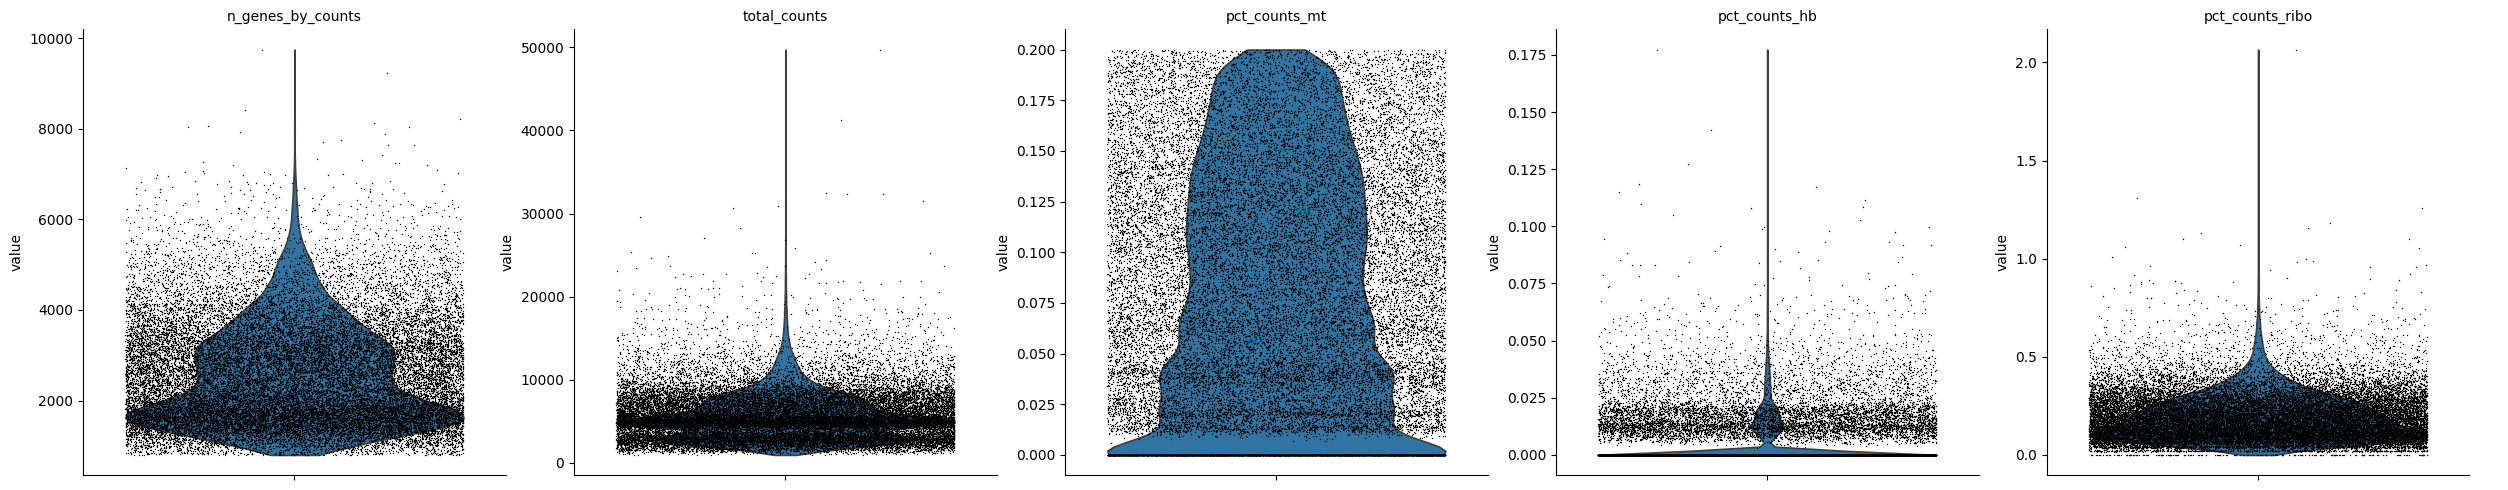

Filtered out 0 cells
CPU times: user 21.1 s, sys: 21.9 s, total: 43 s
Wall time: 7.66 s


In [14]:
%%time 

adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_hb", "pct_counts_ribo"], 
             jitter=0.4,multi_panel=True,)

# filter the cells out that are above the specified thresholds for mitochondrial, ribosomal, and hemoglobin reads
mito_threshold = 5.0
ribo_threshold = 5.0
hb_threshold = 5.0 

adata_size_before = adata.shape[0]

adata = ( adata[(adata.obs.pct_counts_mt <= mito_threshold) &
                (adata.obs.pct_counts_ribo <= ribo_threshold) &
                (adata.obs.pct_counts_hb <= hb_threshold), :].copy()
        )

adata_size_after = adata.shape[0]
num_filtered = adata_size_before - adata_size_after
print(f"Filtered out {num_filtered} cells")

In [15]:
%%time
donor_key = "donor_id"
# predict the doublets with scrublet
sc.pp.scrublet(adata, batch_key = donor_key)
num_doublets = adata[adata.obs.predicted_doublet == True].shape[0]
# filter out the doublets
adata = adata[adata.obs.predicted_doublet == False, :].copy()
print(f"Filtered out {num_doublets} likely doublets")

Filtered out 5 likely doublets
CPU times: user 5min 49s, sys: 4min 31s, total: 10min 20s
Wall time: 3min 52s


2024-11-23 16:05:57,181 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-23 16:06:00,150 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-23 16:06:00,268 - harmonypy - INFO - Iteration 1 of 10
2024-11-23 16:06:07,293 - harmonypy - INFO - Iteration 2 of 10
2024-11-23 16:06:13,971 - harmonypy - INFO - Iteration 3 of 10
2024-11-23 16:06:17,884 - harmonypy - INFO - Converged after 3 iterations


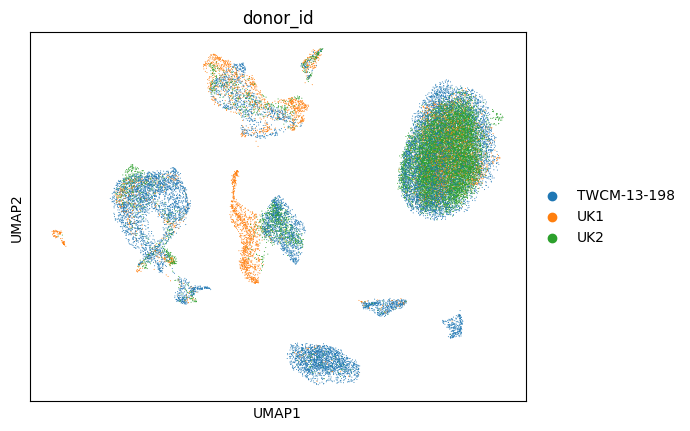

CPU times: user 6min 20s, sys: 22min 54s, total: 29min 14s
Wall time: 55.5 s


In [16]:
%%time
LEIDEN_RES = 0.5
adata = preprocess_adata(adata = adata, 
                         donor_key = "donor_id",
                         leiden_resolution = LEIDEN_RES)

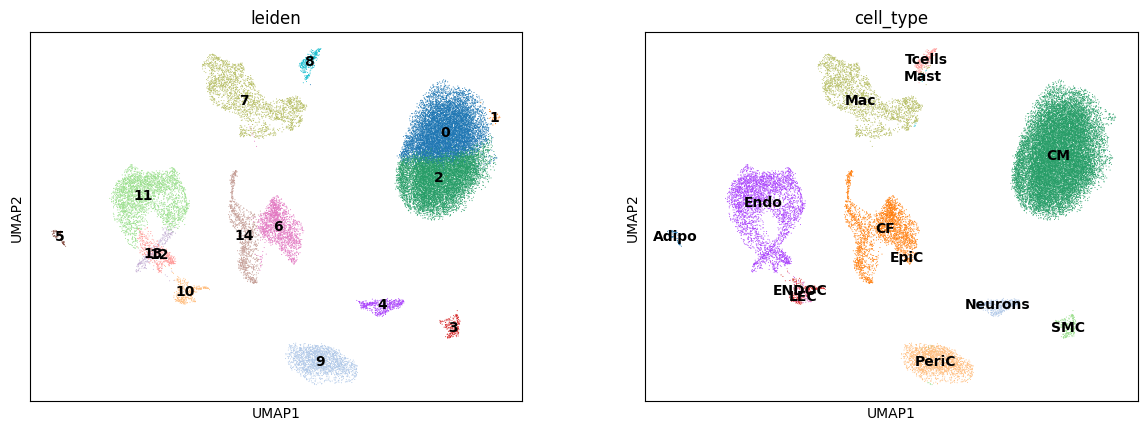

In [17]:
sc.pl.umap(adata, color=["leiden", "cell_type"], size=2, legend_loc = "on data")

### Make cell type annotations consistent

In [18]:
adata.obs["consistent_cell_type"] = adata.obs["cell_type"].map(
    {
        "CM": "Cardiomyocyte",
        "Endo": "Endothelial",
        "CF": "Fibroblast",
        "Mac": "Myeloid",
        "Neurons": "Neuronal",
        "SMC": "vSMC",
        "ENDOC": "Endocardial",
        "Tcells": "Lymphoid",
        "Adipo": "Adipocyte",
        "LEC": "LEC",
        "Mast": "Mast",
        "EpiL": "Endothelial",
        "EpiC": "Epicardial",
        "PeriC": "Pericyte",
    }
)

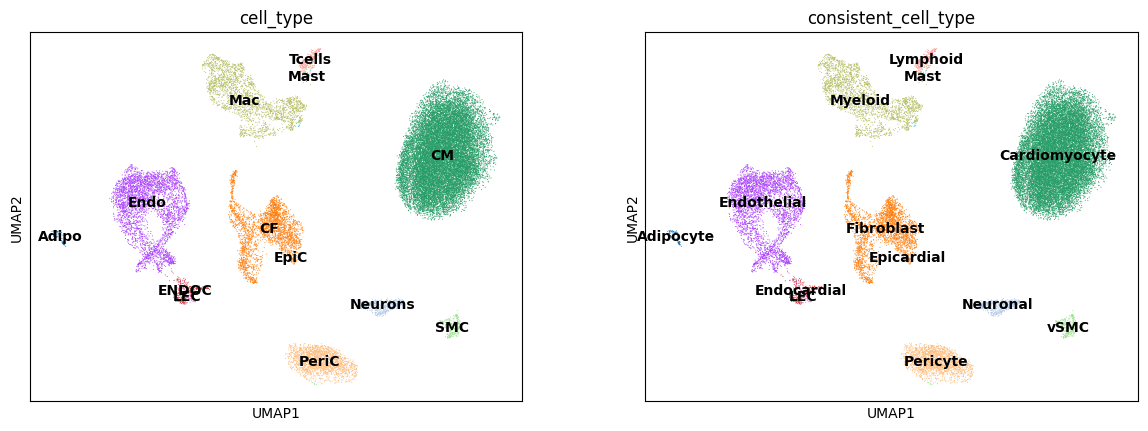

In [19]:
sc.pl.umap(adata, color=["cell_type", "consistent_cell_type"], size=2, legend_loc = "on data")

In [20]:
Counter(adata.obs.consistent_cell_type)

Counter({'Cardiomyocyte': 18486,
         'Endothelial': 3631,
         'Fibroblast': 2804,
         'Myeloid': 2275,
         'Pericyte': 1819,
         'Neuronal': 501,
         'Endocardial': 287,
         'Lymphoid': 272,
         'vSMC': 245,
         'Adipocyte': 92,
         'LEC': 78,
         'Mast': 30,
         'Epicardial': 2})

In [21]:
adata.write("02_processed_Hill_ND.h5ad")